In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

2025-08-09 23:53:14.453210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('./HAM10000_metadata.csv')
image_folder = './images/'

In [3]:
img_size = 64

In [4]:
X = []
y = []

for i in tqdm(range(len(df))):
    img_id = df.iloc[i]['image_id']  # image file name without extension
    label = df.iloc[i]['dx']         # diagnosis/class name
    try:
        # Load image, resize, and normalize pixel values
        img_path = os.path.join(image_folder, img_id + '.jpg')
        img = Image.open(img_path).resize((img_size, img_size))
        img = np.array(img) / 255.0  # scale from 0-255 to 0-1 for faster learning

        # Skip if image is not RGB (just in case)
        if img.shape != (img_size, img_size, 3):
            continue

        # Add image and label to lists
        X.append(img)
        y.append(label)

    except Exception as e:
        print(f"Error loading image {img_id}: {e}")

100%|█████████████████████████████████████| 10015/10015 [01:49<00:00, 91.88it/s]


In [5]:

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape) 


X shape: (10015, 64, 64, 3)
y shape: (10015,)


In [6]:
label_encoder = LabelEncoder()         # create encoder
y_encoded = label_encoder.fit_transform(y)  # convert text → integers
y_onehot = to_categorical(y_encoded)   # convert integers → one-hot matrix

# Save the mapping for later predictions
class_names = label_encoder.classes_
print("Classes:", class_names)

Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [7]:
np.save('./data/X.npy', X)
np.save('./data/y_onehot.npy', y_onehot)
np.save('./data/class_names.npy', class_names)

In [8]:
import numpy as np

# Load preprocessed data
X = np.load('./data/X.npy')
y_onehot = np.load('./data/y_onehot.npy')
class_names = np.load('./data/class_names.npy')

print("X shape:", X.shape)
print("y_onehot shape:", y_onehot.shape)
print("Classes:", class_names)


X shape: (10015, 64, 64, 3)
y_onehot shape: (10015, 7)
Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_onehot
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (8012, 64, 64, 3)
Test size: (2003, 64, 64, 3)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = y_onehot.shape[1]

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(X.shape[1], X.shape[2], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,055 (6.20 MB)

 Trainable params: 1,626,055 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.6656 - loss: 0.9830 - val_accuracy: 0.6735 - val_loss: 0.9002
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.6857 - loss: 0.8847 - val_accuracy: 0.6825 - val_loss: 0.8728
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.6972 - loss: 0.8330 - val_accuracy: 0.6910 - val_loss: 0.8117
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.7232 - loss: 0.7630 - val_accuracy: 0.7119 - val_loss: 0.7789
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.7364 - loss: 0.7209 - val_accuracy: 0.7209 - val_loss: 0.7459
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.7454 - loss: 0.6941 - val_accuracy: 0.7209 - val_loss: 0.7437
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.7589 - loss: 0.6522 - val_accuracy: 0.7309 - val_loss: 0.7275
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.7662 - loss: 0.6291 - 

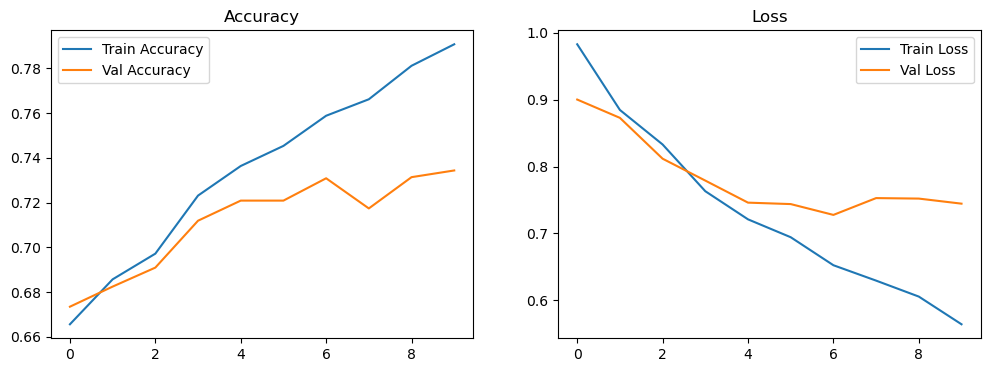

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
from tensorflow.keras.optimizers import Adam

# Load the model (if not already in memory)
# model = tf.keras.models.load_model("your_model_path.h5")

# Compile with a very small learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune for a few more epochs
history_finetune = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# Evaluate again on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Fine-tuned Test Accuracy: {test_acc*100:.2f}%")
print(f"Fine-tuned Test Loss: {test_loss:.4f}")


In [63]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7344 - loss: 0.7444
Test Accuracy: 73.44%
Test Loss: 0.7444


In [65]:
model.save("final_model.h5")


In [67]:
from tensorflow.keras.models import load_model
model = load_model("final_model.h5")


In [69]:
import numpy as np

# Example: predicting on one image
img = X_test[0]  # pick the first test image
img_expanded = np.expand_dims(img, axis=0)
pred = model.predict(img_expanded)

print(f"Predicted class: {np.argmax(pred)}")
print(f"True class: {np.argmax(y_test[0])}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class: 5
True class: 5


In [71]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7344 - loss: 0.7444
Test Accuracy: 73.44%
Test Loss: 0.7444


In [73]:
# Save the trained model
model.save("cancer_model.h5")

# Later, to load it back:
# from tensorflow.keras.models import load_model
# model = load_model("cancer_model.h5")


In [75]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
model = load_model("cancer_model.h5")

# Example: predict on one new sample
sample = X_test[0].reshape(1, X_test.shape[1], X_test.shape[2], X_test.shape[3])
prediction = np.argmax(model.predict(sample), axis=1)
print("Predicted class:", prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted class: 5
